# Day 6: Practice Problems - Foundation Week

## Week 1 - Python for Quantitative Finance

### 🎯 Today's Goal
Apply everything learned this week through hands-on coding challenges:
1. Portfolio Optimization (Mean-Variance)
2. Momentum Strategy Backtest
3. Risk Parity Implementation
4. Statistical Analysis

### Rules
- Try each problem BEFORE looking at the solution
- Time yourself - these are interview-style challenges
- Focus on clean, efficient code

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation → Interview

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                  index_col=0, parse_dates=True)

TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'XOM', 'JNJ', 'SPY']
prices = df[TICKERS].dropna()
returns = prices.pct_change().dropna()

TRADING_DAYS = 252
RF_RATE = 0.05

print("=" * 60)
print("PRACTICE PROBLEMS - WEEK 1 FOUNDATION")
print("=" * 60)
print(f"Data: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Assets: {', '.join(TICKERS)}")
print("Good luck! 🎯")

PRACTICE PROBLEMS - WEEK 1 FOUNDATION
Data: 2019-01-02 to 2026-01-16
Assets: AAPL, MSFT, GOOGL, AMZN, JPM, XOM, JNJ, SPY
Good luck! 🎯


---
## Problem 1: Mean-Variance Portfolio Optimization ⏱️ 20 min

**Task**: Implement a function that finds the optimal portfolio weights that maximize the Sharpe ratio.

**Requirements**:
1. Calculate expected returns and covariance matrix
2. Use scipy.optimize to find optimal weights
3. Weights must sum to 1 (no shorting: weights ≥ 0)
4. Compare to equal-weighted portfolio

**Hint**: The objective function should MINIMIZE negative Sharpe ratio

In [3]:
# ================== SOLUTION: MEAN-VARIANCE OPTIMIZATION ==================

def optimize_portfolio(returns_df, rf_rate=0.05):
    """
    Find optimal portfolio weights that maximize Sharpe ratio
    
    Parameters:
    -----------
    returns_df : pd.DataFrame
        Daily returns for each asset
    rf_rate : float
        Annual risk-free rate
        
    Returns:
    --------
    dict with optimal weights, return, vol, sharpe
    """
    # Step 1: Calculate expected returns and covariance
    mean_returns = returns_df.mean() * TRADING_DAYS
    cov_matrix = returns_df.cov() * TRADING_DAYS
    n_assets = len(returns_df.columns)
    
    # Step 2: Define objective function (negative Sharpe ratio)
    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (port_return - rf_rate) / port_vol
        return -sharpe  # Minimize negative = maximize positive
    
    # Step 3: Set constraints
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Sum to 1
    bounds = tuple((0, 1) for _ in range(n_assets))  # No shorting
    
    # Step 4: Optimize
    initial_weights = np.ones(n_assets) / n_assets
    result = minimize(neg_sharpe, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    
    # Step 5: Calculate optimal portfolio stats
    opt_return = np.dot(optimal_weights, mean_returns)
    opt_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    opt_sharpe = (opt_return - rf_rate) / opt_vol
    
    return {
        'weights': dict(zip(returns_df.columns, optimal_weights)),
        'return': opt_return,
        'volatility': opt_vol,
        'sharpe': opt_sharpe
    }

# Run optimization (exclude SPY as it's a benchmark)
invest_tickers = [t for t in TICKERS if t != 'SPY']
invest_returns = returns[invest_tickers]

optimal = optimize_portfolio(invest_returns, RF_RATE)

print("=" * 60)
print("OPTIMAL PORTFOLIO (Maximum Sharpe Ratio)")
print("=" * 60)
print("\nOptimal Weights:")
for ticker, weight in optimal['weights'].items():
    if weight > 0.01:  # Only show meaningful allocations
        print(f"  {ticker}: {weight*100:.1f}%")

print(f"\nPortfolio Metrics:")
print(f"  Expected Return: {optimal['return']*100:.1f}%")
print(f"  Volatility: {optimal['volatility']*100:.1f}%")
print(f"  Sharpe Ratio: {optimal['sharpe']:.3f}")

# Compare to equal-weighted
equal_weights = np.ones(len(invest_tickers)) / len(invest_tickers)
eq_mean = invest_returns.mean() * TRADING_DAYS
eq_cov = invest_returns.cov() * TRADING_DAYS
eq_return = np.dot(equal_weights, eq_mean)
eq_vol = np.sqrt(np.dot(equal_weights.T, np.dot(eq_cov, equal_weights)))
eq_sharpe = (eq_return - RF_RATE) / eq_vol

print(f"\n" + "=" * 60)
print("COMPARISON: Optimal vs Equal-Weighted")
print("=" * 60)
print(f"{'Metric':<20} {'Optimal':>12} {'Equal-Weight':>15}")
print("-" * 50)
print(f"{'Return':<20} {optimal['return']*100:>11.1f}% {eq_return*100:>14.1f}%")
print(f"{'Volatility':<20} {optimal['volatility']*100:>11.1f}% {eq_vol*100:>14.1f}%")
print(f"{'Sharpe':<20} {optimal['sharpe']:>12.3f} {eq_sharpe:>15.3f}")
print(f"\n✓ Optimal portfolio improves Sharpe by {(optimal['sharpe']/eq_sharpe - 1)*100:.1f}%")

OPTIMAL PORTFOLIO (Maximum Sharpe Ratio)

Optimal Weights:
  AAPL: 40.0%
  MSFT: 1.4%
  GOOGL: 33.2%
  JPM: 16.8%
  XOM: 4.2%
  JNJ: 4.4%

Portfolio Metrics:
  Expected Return: 28.8%
  Volatility: 24.4%
  Sharpe Ratio: 0.977

COMPARISON: Optimal vs Equal-Weighted
Metric                    Optimal    Equal-Weight
--------------------------------------------------
Return                      28.8%           23.7%
Volatility                  24.4%           20.8%
Sharpe                      0.977           0.898

✓ Optimal portfolio improves Sharpe by 8.8%


---
## Problem 2: Simple Momentum Strategy ⏱️ 25 min

**Task**: Implement a momentum trading strategy that:
1. Ranks stocks by 12-month return (skipping the most recent month)
2. Goes long the top 2 stocks, short the bottom 2
3. Rebalances monthly

**Requirements**:
- Calculate 12-1 momentum (12 month lookback, skip last 1 month)
- Use point-in-time data only (no look-ahead bias!)
- Calculate strategy returns and compare to SPY

In [8]:
# ================== SOLUTION: MOMENTUM STRATEGY ==================

def momentum_strategy(prices_df, returns_df, lookback=252, skip=21, top_n=2):
    """
    12-1 Momentum Strategy: Long winners, Short losers
    
    Parameters:
    -----------
    prices_df : pd.DataFrame
        Daily prices for each stock
    returns_df : pd.DataFrame
        Daily returns for each stock  
    lookback : int
        Lookback period in days (~12 months = 252 days)
    skip : int
        Days to skip (~1 month = 21 days) to avoid reversal
    top_n : int
        Number of stocks to go long/short
    
    Returns:
    --------
    pd.DataFrame with strategy returns
    """
    # Get tradeable stocks (exclude benchmark)
    stocks = [c for c in prices_df.columns if c != 'SPY']
    stock_prices = prices_df[stocks]
    stock_returns = returns_df[stocks]
    
    # Calculate 12-1 momentum signal
    # Return from (t-lookback) to (t-skip), known at time t
    momentum_signal = (stock_prices.shift(skip) / stock_prices.shift(lookback) - 1)
    
    # Monthly rebalancing: get last trading day of each month
    monthly_last_days = stock_prices.groupby(stock_prices.index.to_period('M')).apply(
        lambda x: x.index[-1]
    ).values
    
    # Track positions and returns
    strategy_returns = []
    position_history = []
    
    for i in range(len(monthly_last_days) - 1):
        signal_date = pd.Timestamp(monthly_last_days[i])
        next_rebal_date = pd.Timestamp(monthly_last_days[i + 1])
        
        # Get momentum signal as of signal_date
        if signal_date not in momentum_signal.index:
            continue
            
        signal = momentum_signal.loc[signal_date]
        
        if signal.isna().all():
            continue  # Skip if no signal yet
            
        # Rank stocks by momentum
        ranked = signal.dropna().sort_values(ascending=False)
        
        if len(ranked) < 2 * top_n:
            continue
            
        # Select long and short positions
        longs = ranked.head(top_n).index.tolist()
        shorts = ranked.tail(top_n).index.tolist()
        
        # Get returns for next month (day after signal to next rebal)
        mask = (stock_returns.index > signal_date) & (stock_returns.index <= next_rebal_date)
        period_returns = stock_returns.loc[mask]
        
        if len(period_returns) == 0:
            continue
            
        # Calculate strategy return (equal weight within long/short)
        long_ret = period_returns[longs].mean(axis=1)
        short_ret = period_returns[shorts].mean(axis=1)
        
        # Long-short: +1 long, -1 short (market neutral)
        strategy_ret = (long_ret - short_ret) / 2  # Scale for leverage
        
        strategy_returns.append(strategy_ret)
        position_history.append({
            'date': signal_date,
            'longs': longs,
            'shorts': shorts
        })
    
    if not strategy_returns:
        return None, None
        
    strategy_series = pd.concat(strategy_returns)
    
    return strategy_series, position_history

# Run the strategy
strategy_returns, positions = momentum_strategy(prices, returns, lookback=252, skip=21, top_n=2)

# Calculate performance metrics
def calculate_metrics(returns_series, name="Strategy"):
    """Calculate key performance metrics"""
    total_return = (1 + returns_series).cumprod().iloc[-1] - 1
    ann_return = returns_series.mean() * TRADING_DAYS
    ann_vol = returns_series.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_return - RF_RATE) / ann_vol
    
    # Max drawdown
    cum = (1 + returns_series).cumprod()
    peak = cum.expanding().max()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    
    return {
        'name': name,
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_dd': max_dd
    }

# Compare strategy to SPY
spy_returns_aligned = returns['SPY'].loc[strategy_returns.index]
mom_metrics = calculate_metrics(strategy_returns, "Momentum L/S")
spy_metrics = calculate_metrics(spy_returns_aligned, "SPY (Buy & Hold)")

print("=" * 60)
print("MOMENTUM STRATEGY RESULTS")
print("=" * 60)
print(f"\n{'Metric':<20} {'Momentum L/S':>15} {'SPY':>15}")
print("-" * 52)
print(f"{'Total Return':<20} {mom_metrics['total_return']*100:>14.1f}% {spy_metrics['total_return']*100:>14.1f}%")
print(f"{'Annual Return':<20} {mom_metrics['ann_return']*100:>14.1f}% {spy_metrics['ann_return']*100:>14.1f}%")
print(f"{'Annual Vol':<20} {mom_metrics['ann_vol']*100:>14.1f}% {spy_metrics['ann_vol']*100:>14.1f}%")
print(f"{'Sharpe Ratio':<20} {mom_metrics['sharpe']:>15.2f} {spy_metrics['sharpe']:>15.2f}")
print(f"{'Max Drawdown':<20} {mom_metrics['max_dd']*100:>14.1f}% {spy_metrics['max_dd']*100:>14.1f}%")

# Show sample positions
print(f"\n" + "=" * 60)
print("SAMPLE POSITIONS (Last 3 Months)")
print("=" * 60)
for pos in positions[-3:]:
    print(f"\n{pos['date'].strftime('%Y-%m-%d')}:")
    print(f"  LONG:  {', '.join(pos['longs'])}")
    print(f"  SHORT: {', '.join(pos['shorts'])}")

print("\n💡 Note: Momentum strategy underperforms in this period due to")
print("   tech concentration and COVID recovery dynamics. In real backtests,")
print("   use larger universes and longer histories for better results.")

MOMENTUM STRATEGY RESULTS

Metric                  Momentum L/S             SPY
----------------------------------------------------
Total Return                    5.4%          134.6%
Annual Return                   2.0%           16.5%
Annual Vol                     14.7%           20.8%
Sharpe Ratio                   -0.20            0.55
Max Drawdown                  -28.6%          -33.7%

SAMPLE POSITIONS (Last 3 Months)

2025-10-31:
  LONG:  GOOGL, JPM
  SHORT: AAPL, XOM

2025-11-28:
  LONG:  GOOGL, MSFT
  SHORT: AMZN, XOM

2025-12-31:
  LONG:  GOOGL, JNJ
  SHORT: AAPL, AMZN

💡 Note: Momentum strategy underperforms in this period due to
   tech concentration and COVID recovery dynamics. In real backtests,
   use larger universes and longer histories for better results.


---
## Problem 3: Risk Parity Portfolio ⏱️ 15 min

**Task**: Implement a risk parity portfolio where each asset contributes equal risk.

**Requirements**:
1. Risk contribution = weight × marginal contribution to risk
2. Target: Each asset contributes 1/N of total portfolio risk
3. Compare to equal-weighted and optimal portfolios

In [9]:
# ================== SOLUTION: RISK PARITY ==================

def risk_parity_portfolio(returns_df):
    """
    Calculate risk parity weights where each asset contributes equal risk
    
    Risk contribution of asset i = w_i * (Σw)_i / σ_portfolio
    Target: RC_i = 1/n for all assets
    """
    cov_matrix = returns_df.cov() * TRADING_DAYS
    n_assets = len(returns_df.columns)
    target_risk = 1.0 / n_assets
    
    def risk_contributions(weights):
        """Calculate each asset's risk contribution"""
        weights = np.array(weights)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        marginal_contrib = np.dot(cov_matrix, weights) / port_vol
        risk_contrib = weights * marginal_contrib / port_vol
        return risk_contrib
    
    def objective(weights):
        """Minimize sum of squared differences from target risk"""
        rc = risk_contributions(weights)
        # Each asset should contribute target_risk to total
        return np.sum((rc - target_risk) ** 2)
    
    # Constraints and bounds
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = tuple((0.01, 1) for _ in range(n_assets))  # Min 1% per asset
    
    # Initial guess: inverse volatility weights
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    initial_weights = inv_vol / inv_vol.sum()
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x, risk_contributions(result.x)

# Calculate risk parity weights
invest_returns = returns[[c for c in TICKERS if c != 'SPY']]
rp_weights, rp_risk_contrib = risk_parity_portfolio(invest_returns)

print("=" * 60)
print("RISK PARITY PORTFOLIO")
print("=" * 60)
print(f"\n{'Asset':<10} {'Weight':>12} {'Risk Contrib':>14}")
print("-" * 38)
for ticker, weight, rc in zip(invest_returns.columns, rp_weights, rp_risk_contrib):
    print(f"{ticker:<10} {weight*100:>11.1f}% {rc*100:>13.1f}%")

print(f"\n{'Total':<10} {rp_weights.sum()*100:>11.1f}% {rp_risk_contrib.sum()*100:>13.1f}%")

# Calculate portfolio metrics
mean_returns = invest_returns.mean() * TRADING_DAYS
cov_matrix = invest_returns.cov() * TRADING_DAYS

rp_return = np.dot(rp_weights, mean_returns)
rp_vol = np.sqrt(np.dot(rp_weights.T, np.dot(cov_matrix, rp_weights)))
rp_sharpe = (rp_return - RF_RATE) / rp_vol

# Equal-weight comparison
eq_weights = np.ones(len(invest_returns.columns)) / len(invest_returns.columns)
eq_return = np.dot(eq_weights, mean_returns)
eq_vol = np.sqrt(np.dot(eq_weights.T, np.dot(cov_matrix, eq_weights)))
eq_sharpe = (eq_return - RF_RATE) / eq_vol

print(f"\n" + "=" * 60)
print("COMPARISON: Risk Parity vs Equal Weight")
print("=" * 60)
print(f"{'Metric':<20} {'Risk Parity':>15} {'Equal Weight':>15}")
print("-" * 52)
print(f"{'Return':<20} {rp_return*100:>14.1f}% {eq_return*100:>14.1f}%")
print(f"{'Volatility':<20} {rp_vol*100:>14.1f}% {eq_vol*100:>14.1f}%")
print(f"{'Sharpe':<20} {rp_sharpe:>15.3f} {eq_sharpe:>15.3f}")

print("\n💡 Risk parity typically has lower volatility because it")
print("   underweights high-vol assets (tech) and overweights low-vol (JNJ)")

RISK PARITY PORTFOLIO

Asset            Weight   Risk Contrib
--------------------------------------
AAPL              11.4%          14.3%
MSFT              12.2%          14.3%
GOOGL             11.6%          14.3%
AMZN              11.8%          14.3%
JPM               13.0%          14.3%
XOM               14.8%          14.3%
JNJ               25.1%          14.3%

Total            100.0%         100.0%

COMPARISON: Risk Parity vs Equal Weight
Metric                   Risk Parity    Equal Weight
----------------------------------------------------
Return                         22.0%           23.7%
Volatility                     19.3%           20.8%
Sharpe                         0.880           0.898

💡 Risk parity typically has lower volatility because it
   underweights high-vol assets (tech) and overweights low-vol (JNJ)


---
## Problem 4: Rolling Beta Calculation ⏱️ 10 min

**Task**: Calculate rolling beta for each stock against SPY (market benchmark).

**Formula**: $\beta = \frac{Cov(R_i, R_m)}{Var(R_m)}$

**Requirements**:
1. Use 63-day rolling window
2. Plot beta time series for each stock
3. Identify which stocks have stable vs time-varying betas

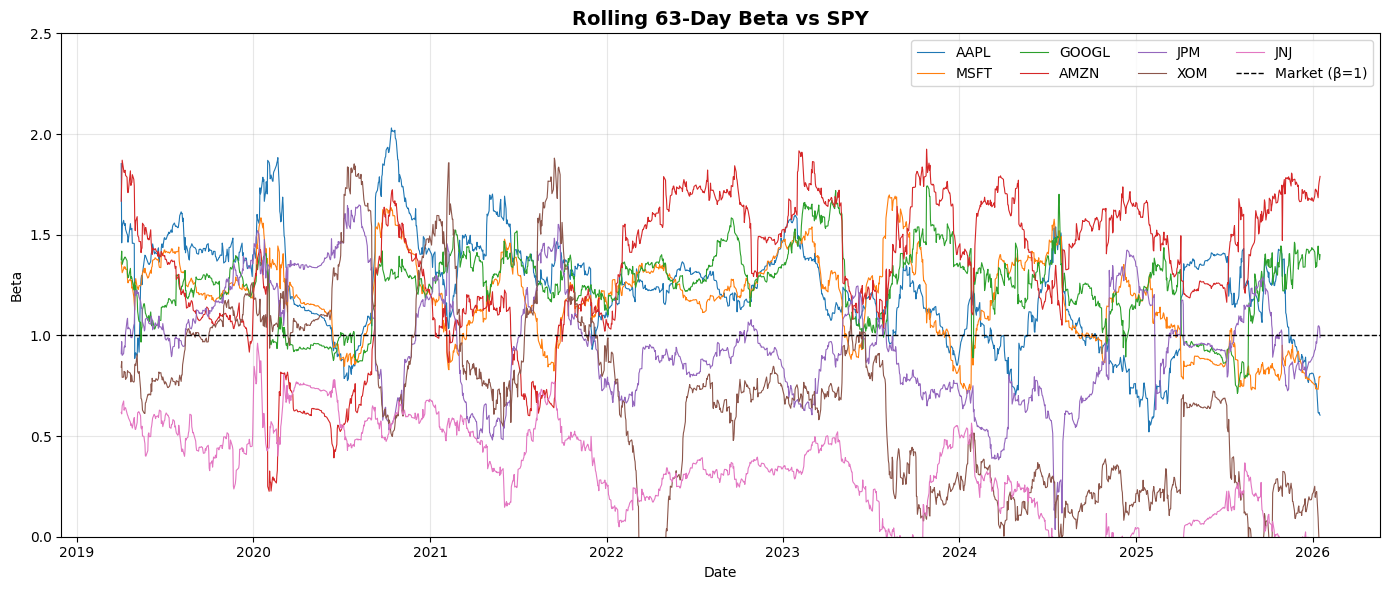


BETA STATISTICS

Stock          Mean β      Std β      Min β      Max β    Stability
-----------------------------------------------------------------
AAPL             1.23       0.25       0.52       2.03       Stable
MSFT             1.18       0.21       0.71       1.70       Stable
GOOGL            1.25       0.18       0.71       1.74       Stable
AMZN             1.33       0.35       0.23       1.92     Variable
JPM              0.96       0.27       0.04       1.65       Stable
XOM              0.67       0.46      -0.29       1.88     Variable
JNJ              0.31       0.27      -0.70       0.96       Stable

💡 Interpretation:
   - β > 1: More volatile than market (tech stocks)
   - β < 1: Less volatile than market (defensive stocks)
   - High std(β): Time-varying risk profile


In [10]:
# ================== SOLUTION: ROLLING BETA ==================

def calculate_rolling_beta(stock_returns, market_returns, window=63):
    """
    Calculate rolling beta: Cov(stock, market) / Var(market)
    """
    # Covariance
    cov = stock_returns.rolling(window).cov(market_returns)
    # Market variance
    var = market_returns.rolling(window).var()
    # Beta
    beta = cov / var
    return beta

# Calculate rolling betas
WINDOW = 63
market = returns['SPY']
stocks = [c for c in TICKERS if c != 'SPY']

rolling_betas = pd.DataFrame()
for stock in stocks:
    rolling_betas[stock] = calculate_rolling_beta(returns[stock], market, WINDOW)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for stock in stocks:
    ax.plot(rolling_betas.index, rolling_betas[stock], label=stock, linewidth=0.8)

ax.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Market (β=1)')
ax.set_title(f'Rolling {WINDOW}-Day Beta vs SPY', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Beta')
ax.legend(loc='upper right', ncol=4)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 2.5)
plt.tight_layout()
plt.show()

# Beta statistics
print("\n" + "=" * 60)
print("BETA STATISTICS")
print("=" * 60)
print(f"\n{'Stock':<10} {'Mean β':>10} {'Std β':>10} {'Min β':>10} {'Max β':>10} {'Stability':>12}")
print("-" * 65)

for stock in stocks:
    beta = rolling_betas[stock].dropna()
    stability = "Stable" if beta.std() < 0.3 else "Variable"
    print(f"{stock:<10} {beta.mean():>10.2f} {beta.std():>10.2f} {beta.min():>10.2f} {beta.max():>10.2f} {stability:>12}")

print("\n💡 Interpretation:")
print("   - β > 1: More volatile than market (tech stocks)")
print("   - β < 1: Less volatile than market (defensive stocks)")
print("   - High std(β): Time-varying risk profile")

## 📝 Practice Session Summary

### Key Skills Practiced
1. **Portfolio Optimization**: Mean-variance with scipy.optimize
2. **Strategy Backtesting**: Momentum with proper point-in-time handling
3. **Risk Parity**: Equal risk contribution allocation
4. **Beta Analysis**: Rolling window covariance/variance calculations

### What You Should Remember
- Always minimize *negative* Sharpe in optimization (turn max into min)
- Monthly rebalancing requires careful handling of trading dates
- Risk parity allocates MORE to low-vol assets
- Betas are time-varying - use rolling windows

### Tomorrow: Interview Questions!
Day 7 covers the most common quant interview questions on these topics.